# Nonholonomic RRT 

by Emmy Chow

This theory of operation has consulted the following resources:

[RRT Implementation for Non-holonomic Robot (Part 2 - for car-like robots](https://www.linkedin.com/pulse/rrt-implementation-non-holonomic-robot-part-2-car-like-ankit-saini)

[Nonholonomic Mobile Robot Motion Planning](http://msl.cs.uiuc.edu/~lavalle/cs576_1999/projects/junqu/)

[RRT Path Planning using a Dynamic Vehicle Model](https://www.cs.cmu.edu/~motionplanning/reading/rosssiddpresentation.pdf)

In [28]:
import matplotlib.pyplot as plt
import kdtree
from mtree import MTree
from src.rrtutil import dist2, diff
import numpy as np


def rotate(n, theta):
    """
    Equivalent to (but faster than)
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    n[:2] = R @ n[:2]

    return(n)
    """

    c = np.cos(theta)
    s = np.sin(theta)
    
    n0 = n[0].copy()
    n1 = n[1].copy()

    n[0] = n0 * c - n1 * s
    n[1] = n0 * s + n1 * c

    return(n)

def plus_minus(gen):
    """
    Take a generator of and make it alternate in sign.
    
    [1, 2, 3] -> [1, -1, 2, -2, 3, -3]
    """
    for x in gen:
        yield (x)
        yield (-x)

In [54]:
from numpy import pi

L = 0.1
v = 1
T = 0.1  # Amount of time to simulate into the future

N_phi = 21  # Number of turning angles to generate
N_t = 10  # Resolution of Euler integration

phi = np.linspace(-0.45 * np.pi, 0.45 * np.pi, N_phi)
primatives = np.zeros((N_t, N_phi, 3))

primatives[0] = 0

dt = T / N_t

for i in range(1, N_t):
    primatives[i, :, 0] = (
        primatives[i - 1, :, 0] + 
        v * np.cos(phi) * np.cos(primatives[i - 1, :, 2] * 2 * pi) * dt
    )
    
    primatives[i, :, 1] = (
        primatives[i - 1, :, 1] + 
        v * np.cos(phi) * np.sin(primatives[i - 1, :, 2] * 2 * pi) * dt
    )
    
    primatives[i, :, 2] = (
        primatives[i - 1, :, 2] + 
        v / L * np.sin(phi) / (2 * pi) * dt
    )
    
candidates = primatives[-1, :]

In [118]:
from numpy import ndarray, asarray
from collections import deque
from numpy.typing import ArrayLike


class RRTNode(ndarray):
    def __new__(cls, arr: ArrayLike):
        n = asarray(arr).view(cls)
        return (n)

    # This is how you add properties to ndarray subclasses evidently.
    def __array_finalize__(self, obj):
        if obj is not None:
            # Deques have O(1) insertion at the end, no reallactions necessary!
            self.u = getattr(obj, 'u', [None] * 3)
            self.parent = getattr(obj, 'parent', None)
            self.children = getattr(obj, 'children', deque())



prims = np.concatenate((primatives, -primatives))
for t in range(N_t):
    for i, row in enumerate(prims[t]):
        n = RRTNode(row)
        n.u[0] = phi[i]
        n.u[1] = v 
        n.u[2] = (0, t)
        
for t in range(N_t, 2 * N_t - 1):
    for i, row in enumerate(prims[t]):
        n = RRTNode(row)
        n.u[0] = i
        n.u[1] = -v
        n.u[2] = (N_t, t)

    break

In [119]:
prims[10:13, 0, :2][:, 0]

array([-0.        , -0.00156434, -0.00312107])

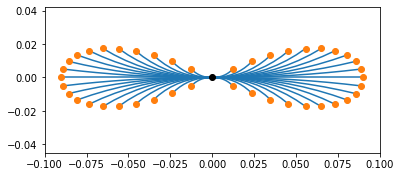

In [27]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
ax.set_xlim([-0.1, 0.1])
ax.set_ylim([-0.045, 0.042])

for i in range(primatives.shape[1]):
    ax.plot(primatives[:, i, 0], primatives[:, i, 1], 'C0')
    ax.plot(-primatives[:, i, 0], -primatives[:, i, 1], 'C0')

ax.plot(0, 0, 'ko')

ax.plot(candidates[:, 0],  candidates[:, 1], 'C1o')
ax.plot(-candidates[:, 0],  -candidates[:, 1], 'C1o')


plt.show()

In [17]:
np.concatenate((primatives, -primatives))[2*N_t - 1]

array([[-0.02505154,  0.01001818,  0.13622881],
       [-0.03486739,  0.0132011 ,  0.12960693],
       [-0.04442649,  0.01560197,  0.12094107],
       [-0.05358944,  0.01706019,  0.11036789],
       [-0.06218092,  0.01746499,  0.09805415],
       [-0.06999563,  0.01676706,  0.08419404],
       [-0.07681032,  0.01498744,  0.06900613],
       [-0.08240092,  0.01222198,  0.05272996],
       [-0.08656282,  0.00863944,  0.0356222 ],
       [-0.08913145,  0.0044722 ,  0.01795266],
       [-0.09      , -0.        , -0.        ],
       [-0.08913145, -0.0044722 , -0.01795266],
       [-0.08656282, -0.00863944, -0.0356222 ],
       [-0.08240092, -0.01222198, -0.05272996],
       [-0.07681032, -0.01498744, -0.06900613],
       [-0.06999563, -0.01676706, -0.08419404],
       [-0.06218092, -0.01746499, -0.09805415],
       [-0.05358944, -0.01706019, -0.11036789],
       [-0.04442649, -0.01560197, -0.12094107],
       [-0.03486739, -0.0132011 , -0.12960693],
       [-0.02505154, -0.01001818, -0.136

In [340]:
primative_tree = MTree(dist)
for c in plus_minus(candidates):
    primative_tree.add(c)

In [341]:
p = np.array([0.6, 0.4, 0.1])
n = np.array([0.62, 0.45, 0.2])

x = rotate(diff(n, p), -p[2] * 2 * pi)
n_primative = primative_tree.search(x)[0].obj  # nearest primative

print(x)
print(n_primative)
print(dist(x, n_primative))

[0.0455696  0.02869514 0.1       ]
[0.05358944 0.01706019 0.11036789]
0.01752664352385785


In [342]:
for c in plus_minus(candidates):
    print(c, ":", dist(x, c))

[ 0.02505154 -0.01001818 -0.13622881] : 0.24025770277371836
[-0.02505154  0.01001818  0.13622881] : 0.08153957054381522
[ 0.03486739 -0.0132011  -0.12960693] : 0.23364326285319847
[-0.03486739  0.0132011   0.12960693] : 0.08710192073571639
[ 0.04442649 -0.01560197 -0.12094107] : 0.22534084433363596
[-0.04442649  0.01560197  0.12094107] : 0.09332339979383093
[ 0.05358944 -0.01706019 -0.11036789] : 0.21543564747547347
[-0.05358944  0.01706019  0.11036789] : 0.10037619835656285
[ 0.06218092 -0.01746499 -0.09805415] : 0.20403955656706543
[-0.06218092  0.01746499  0.09805415] : 0.108351638181807
[ 0.06999563 -0.01676706 -0.08419404] : 0.19128744214058033
[-0.06999563  0.01676706  0.08419404] : 0.1172494399818024
[ 0.07681032 -0.01498744 -0.06900613] : 0.177333647315711
[-0.07681032  0.01498744  0.06900613] : 0.12698569396061532
[ 0.08240092 -0.01222198 -0.05272996] : 0.16234899798038385
[-0.08240092  0.01222198  0.05272996] : 0.13741279380300178
[ 0.08656282 -0.00863944 -0.0356222 ] : 0.146

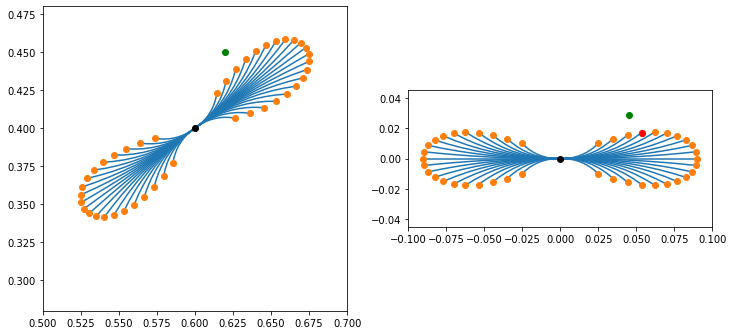

In [343]:
fig, ax = plt.subplots(1, 2, subplot_kw={'aspect': 'equal'}, figsize=(12, 9))

ax[0].set_xlim([-0.1 + p[0], 0.1 + p[0]])
ax[0].set_ylim([0.28, 0.48])

ax[1].set_xlim([-0.1, 0.1])
ax[1].set_ylim([-0.045, 0.045])

for i in range(primatives.shape[1]):
    paths = rotate(primatives[:, i, :2].T.copy(), 2 * pi * p[2]).T
    
    ax[0].plot(
        paths[:, 0] + p[0], 
        paths[:, 1] + p[1], 'C0'
    )
    
    ax[0].plot(
        -paths[:, 0] + p[0], 
        -paths[:, 1] + p[1], 'C0'
    )

ax[0].plot(p[0], p[1], 'ko')
ax[0].plot(n[0], n[1], 'go')

path_ends = rotate(candidates[:, :2].T.copy(), 2 * pi * p[2]).T

ax[0].plot(
    path_ends[:, 0] + p[0],  
    path_ends[:, 1] + p[1], 
    'C1o'
)

ax[0].plot(
    -path_ends[:, 0] + p[0],  
    -path_ends[:, 1] + p[1], 
    'C1o'
)

for i in range(primatives.shape[1]):
    ax[1].plot(primatives[:, i, 0], primatives[:, i, 1], 'C0')
    ax[1].plot(-primatives[:, i, 0], -primatives[:, i, 1], 'C0')

ax[1].plot(0, 0, 'ko')
ax[1].plot(candidates[:, 0],  candidates[:, 1], 'C1o')
ax[1].plot(-candidates[:, 0],  -candidates[:, 1], 'C1o')

ax[1].plot(x[0], x[1], 'go')
ax[1].plot(n_primative[0], n_primative[1], 'ro')

plt.show()